# 一、导入包

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0] 
    tf.config.experimental.set_memory_growth(gpu0, True) 
    tf.config.set_visible_devices([gpu0],"GPU")
    
import matplotlib.pyplot as plt
import os,PIL,pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings("ignore")#忽略警告信息

plt.rcParams['axes.unicode_minus'] = False 
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 二、导入数据

In [3]:
import pathlib

data_dir = "./fruit36_dataset/"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print("图片总数为：",image_count)

图片总数为： 3115


In [4]:
batch_size = 8
img_height = 224
img_width  = 224

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3115 files belonging to 36 classes.
Using 2492 files for training.


2024-03-14 22:02:08.171389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 22:02:08.722714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46714 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:56:00.0, compute capability: 8.6


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3115 files belonging to 36 classes.
Using 623 files for validation.


In [7]:
class_names = train_ds.class_names
print("数据类别有：",class_names)

数据类别有： ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


## 检查数据

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 224, 224, 3)
(8,)


2024-03-14 22:02:21.292467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:02:21.299616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


## 3. 配置数据集

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image,label):
    return (image/255.0,label)

train_ds = (
    train_ds.cache()

    .map(train_preprocessing)    # 这里可以设置预处理函数

    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()

    .map(train_preprocessing)    # 这里可以设置预处理函数

    .prefetch(buffer_size=AUTOTUNE)
)

# 三、构建模型

In [10]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization,Activation

# 加载预训练模型
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

for layer in base_model.layers:
    layer.trainable = True
    
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)

X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)

X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(len(class_names), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 [==============================] - 35s 0us/step


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 四、编译

In [11]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 五、训练模型

In [12]:
history  = model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=20
                    )

Epoch 1/20


2024-03-14 22:03:29.381708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:29.390727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:30.070600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:30.079585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:30.105352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:30.704461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:30.713543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:30.783647: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-03-14 22:03:30.915078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

  7/312 [..............................] - ETA: 15s - loss: 3.4418 - accuracy: 0.0893

2024-03-14 22:03:34.637337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/312 [========>.....................] - ETA: 10s - loss: 3.3748 - accuracy: 0.1020

2024-03-14 22:03:39.110501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/312 [=========>....................] - ETA: 10s - loss: 3.3633 - accuracy: 0.1040

2024-03-14 22:03:39.534671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:39.600761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/312 [===========>..................] - ETA: 8s - loss: 3.3071 - accuracy: 0.1343

2024-03-14 22:03:40.993490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/312 [============>.................] - ETA: 8s - loss: 3.2918 - accuracy: 0.1397

2024-03-14 22:03:41.455088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


312/312 [==============================] - ETA: 0s - loss: 3.1030 - accuracy: 0.2187

2024-03-14 22:03:50.788205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:51.176285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:51.518666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:52.038383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:52.042417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:52.106181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-03-14 22:03:52.133184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


312/312 [==============================] - 29s 61ms/step - loss: 3.1030 - accuracy: 0.2187 - val_loss: 3.6223 - val_accuracy: 0.0369
Epoch 2/20
312/312 [==============================] - 16s 51ms/step - loss: 2.5188 - accuracy: 0.5429 - val_loss: 3.2348 - val_accuracy: 0.2263
Epoch 3/20
312/312 [==============================] - 16s 51ms/step - loss: 2.2248 - accuracy: 0.7095 - val_loss: 2.4634 - val_accuracy: 0.5570
Epoch 4/20
312/312 [==============================] - 16s 50ms/step - loss: 2.0310 - accuracy: 0.7933 - val_loss: 2.2135 - val_accuracy: 0.6340
Epoch 5/20
312/312 [==============================] - 16s 50ms/step - loss: 1.8701 - accuracy: 0.8327 - val_loss: 2.0949 - val_accuracy: 0.6244
Epoch 6/20
312/312 [==============================] - 16s 50ms/step - loss: 1.7203 - accuracy: 0.8579 - val_loss: 2.0313 - val_accuracy: 0.6469
Epoch 7/20
312/312 [==============================] - 15s 49ms/step - loss: 1.5800 - accuracy: 0.8756 - val_loss: 1.8934 - val_accuracy: 0.6597
Epo

In [13]:
model.save("fruit36_resnet50_model.h5")

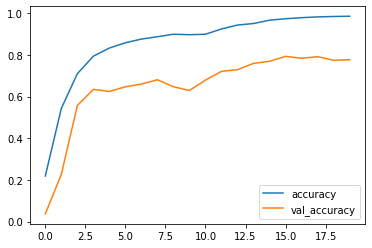

In [14]:
history.history.keys()
plt.plot(history.epoch, history.history.get('accuracy'), label='accuracy')
plt.plot(history.epoch, history.history.get('val_accuracy'), label='val_accuracy')
plt.legend()

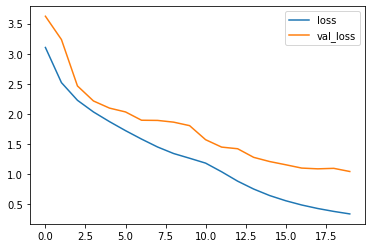

In [15]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

# 六、预测

In [16]:
import tensorflow as tf
 

model = tf.keras.models.load_model('fruit36_resnet50_model.h5')

In [16]:
import numpy as np

class_names =  ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

test_img = './fruit36_dataset/apple/Image_1.jpg'
test_tensor = load_and_preprocess_image(test_img)
test_tensor = tf.expand_dims(test_tensor, axis=0)
pred = model.predict(test_tensor)
pred_id = int(np.argmax(pred))
pred_name = class_names[pred_id]
print("预测结果：{}".format(pred_name))
print("预测ID：{}".format(pred_id))

1/1 [==============================] - 1s 1s/step
预测结果：apple
预测ID：0
